In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Small EDA

In [3]:
train = pd.read_parquet("../datasets/train_data.parquet")
validation = pd.read_parquet("../datasets/validation_data.parquet")
test = pd.read_parquet("../datasets/test_data.parquet")

In [4]:
train.head()

,ID,N_Value,SC_Value,ST_Value,3999.64,4003.497,4007.354,4011.211,4015.068,4018.925,...,9966.315,9970.173,9974.029,9977.887,9981.743,9985.601,9989.457,9993.314,9997.171,10001.03
5132,citgillea20231210_26,3.736495,102.792922,140.982495,0.620981,0.620960,0.620588,0.620418,0.619960,0.619224,...,0.254396,0.254285,0.254405,0.254508,0.254852,0.254596,0.254308,0.254105,0.253997,0.254025
3088,citGillea20220906_50,3.628331,84.671268,66.970558,0.851571,0.850940,0.850228,0.849578,0.849051,0.848231,...,0.467714,0.467965,0.467861,0.467259,0.467353,0.467631,0.467558,0.467763,0.467809,0.468077
4017,citgillea20220519_53,2.764372,80.681693,44.726191,0.679428,0.678999,0.678307,0.677786,0.676987,0.675997,...,0.271806,0.271385,0.271398,0.271644,0.271330,0.271162,0.271055,0.270907,0.271344,0.271084
3245,citGillea20221115_57,3.752433,79.176108,22.696782,0.625734,0.625575,0.624886,0.624427,0.623974,0.623252,...,0.205636,0.205407,0.205769,0.205836,0.205590,0.205593,0.205551,0.205442,0.205540,0.205490
3462,citKfalea20220804_39,2.452065,74.622302,58.165634,0.826860,0.827003,0.826862,0.826531,0.825913,0.825140,...,0.341287,0.341286,0.341587,0.341533,0.341154,0.341421,0.341480,0.340933,0.341187,0.341442


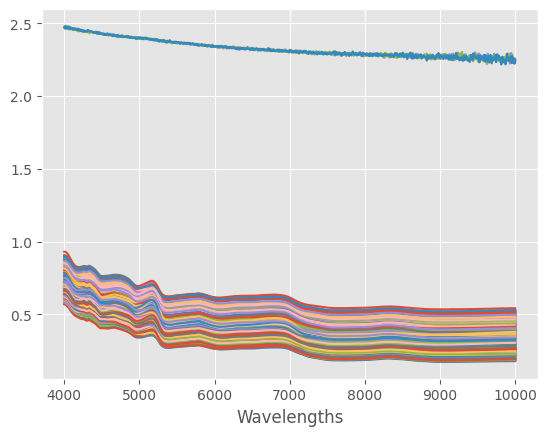

In [5]:
wave_columns = train.columns[4:]
wavelengths = [float(wavelength) for wavelength in wave_columns]

with plt.style.context('ggplot'):
    plt.plot(wavelengths,train[wave_columns].T)
    plt.xlabel("Wavelengths")
    plt.show()

#### Features Correlations

In [16]:
wave_data = train[wave_columns].to_numpy()
correlation_matrix = np.corrcoef(wave_data, rowvar=False)
print(correlation_matrix)

[[1.         0.99999585 0.99999226 ... 0.9438802  0.9439706  0.94403681]
 [0.99999585 1.         0.9999972  ... 0.94401224 0.94410334 0.94417237]
 [0.99999226 0.9999972  1.         ... 0.9441773  0.94426745 0.94433258]
 ...
 [0.9438802  0.94401224 0.9441773  ... 1.         0.99999542 0.9999688 ]
 [0.9439706  0.94410334 0.94426745 ... 0.99999542 1.         0.99997797]
 [0.94403681 0.94417237 0.94433258 ... 0.9999688  0.99997797 1.        ]]


#### Response Variable Correlations

In [27]:
response_dataset = train[train.columns[1:4]]
response_dataset.corr()

,N_Value,SC_Value,ST_Value
N_Value,1.000000,-0.220274,-0.240650
SC_Value,-0.220274,1.000000,0.876047
ST_Value,-0.240650,0.876047,1.000000


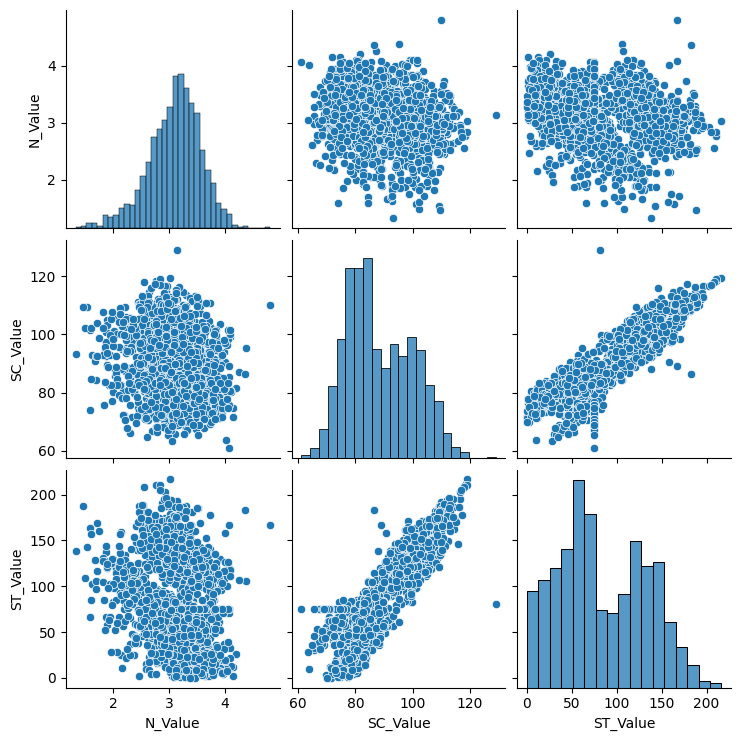

In [30]:
sns.pairplot(response_dataset)
plt.show()

# Partial Least Squares Regression

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from PLSR import MultiOutputPLSRegression

### Preprocessing the data

In [10]:
# Preparing data for optimization
scalers = [(StandardScaler(),StandardScaler()) for _ in range(3)]
datasets = [("train",train),("validation",validation),("test",test)]

def splitData(df):
    X,Y = df[df.columns[4:]], df[df.columns[1:4]]
    return X,Y

transformed_data = {}
for (features_scaler,target_scaler), (dataset_name,dataset) in zip(scalers, datasets):
    X,Y = splitData(dataset)
    scaled_features = features_scaler.fit_transform(X)
    scaled_targets = target_scaler.fit_transform(Y)
    transformed_data[dataset_name] = (scaled_features,scaled_targets)

In [11]:
X_train,Y_train = transformed_data['train']
X_val,Y_val = transformed_data['validation']
X_test,Y_test = transformed_data['test']

### Optimizing the number of components

In [12]:
# choose the maximum number of components to test
maximum_number_of_components = 50

# Initialize the multiPLSR model
multiPLSR = MultiOutputPLSRegression()

# Find the optimal number of components
multiPLSR.findOptimalNumberOfComponents(X_train,Y_train,X_val,Y_val,maximum_number_of_components)
print()


Optimizing Number of Components: 100%|██████████| 50/50 [01:58<00:00,  2.37s/it]

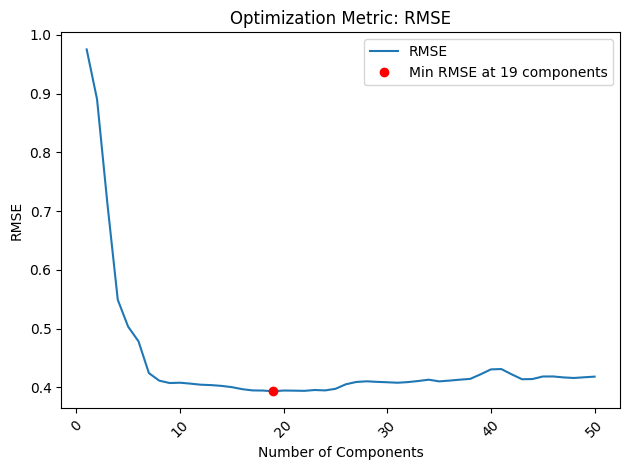

In [13]:
# Plot RMSE as a function of the number of components
multiPLSR.plotMetricResults()

### Training the model using CV-10

In [14]:
optimal_n_components = 28
multiPLSR.crossValidation(X_train,Y_train, optimal_n_components)
print()

Cross Validation: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

### Testing the model

In [15]:
Y_pred = multiPLSR.multiPLSR.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)

print(f' RMSE for N_value: {rmse[0]}\n RMSE for SC_Value: {rmse[1]}\n RMSE for ST_Value: {rmse[2]}\n Average RMSE: {np.mean(rmse)}')

 RMSE for N_value: 0.39851444802295893
 RMSE for SC_Value: 0.45588062026239956
 RMSE for ST_Value: 0.5793456807850708
 Average RMSE: 0.4779135830234764
